# Fine-Tuning For Classification
- Introduction to training model for doing different kind of tasks

The most common ways to fine-tune language models are instruction fine-tuning and classification fine-tuning:

**Instruction Fine-Tuning:**
- Training a language model on a set of tasks using specific instructions to improve its ability to understand and execute tasks described in natural language prompts

**Classification Fine-Tuning:**
- The model is trained to recognize a specific set of class labels, such as "spam" and "not spam"
- Examples of classification tasks extend beyond LLMs and email filtering: they include identifying different species of plants from images; categorizing news articles into topics...

In [1]:
# Prepare Dataset for Classification Fine-Tuning
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print("Data file already exists. Skipping download.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Data file extracted to {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

Data file extracted to sms_spam_collection\SMSSpamCollection.tsv


In [2]:
import pandas as pd

df = pd.read_csv(data_file_path, sep='\t', header=None, names=['Label', 'Text'])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
# Create a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    ham_samples = df[df['Label'] == 'ham'].sample(n=num_spam, random_state=123)

    balanced_df = pd.concat([ham_samples, df[df['Label'] == 'spam']])
    return balanced_df

balanced_df = create_balanced_dataset(df)
balanced_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [4]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df.head()


,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [5]:
# Split the dataset into 3 parts: train, validation, test
# 70% train, 10% validation, 20% test

def random_split(df, train_frac,validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)  # Shuffle the dataframe
    train_end = int(len(df) * train_frac)
    val_end = int(len(df) * (train_frac + validation_frac))

    train_df = df.iloc[:train_end]
    validation_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [9]:
# Save to CSV files
train_df.to_csv("train.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

In [8]:
# Creating data loaders
import tiktoken
import torch
from torch.utils.data import DataLoader, Dataset


"""
Build PyTorch DataLoaders for variable-length textmessages (spam dataset): Since messages have different lengths, batching requires
all sequences in a batch to have th same length -> 2 ways to achieve this:

1. Truncate to the shortest message:
- Simple but wastes data
- Worse model performance

2. Pad to the longest message
- Preserves all data
- Slightly more complex implementation but better model performance
- Chosen as the better option 

"""

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))  # gpt2 endoftext token ID is 50256

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,pad_id=50256):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.encoded_texts = [
            tokenizer.encode(text, allowed_special={"<|endoftext|>"}) for text in self.data['Text']
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        self.encoded_texts = [
            encoded_text + [pad_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self,idx):
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_len = 0
        for encoded_text in self.encoded_texts:
            if len(encoded_text) > max_len:
                max_len = len(encoded_text)
        return max_len

[50256]


In [12]:
# Preparing Training, Validation, and Test Datasets

train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)
print(f"Training dataset max length: {train_dataset.max_length}")

validation_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

test_dataset = SpamDataset(
    csv_file = "test.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

Training dataset max length: 120


In [13]:
from torch.utils.data import DataLoader

"""
Once the SpamDataset objects are created, we can build PyTorch DataLoaders
DataLoaders are used for:
- Batching the data:
- Shuffling the data
- Automatic padding - even though we have already padded the sequences to the max length in the dataset, DataLoader can handle this as well
- Converts Python Data -> PyTorch Tensors
"""

num_workers = 0  # Number of subprocesses to use for data loading
batch_size = 8
torch.manual_seed(123)  # For reproducibility

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True
)

validation_loader = DataLoader(
    dataset = validation_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    drop_last = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    drop_last = False
)

In [48]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch shape:", input_batch.shape)
print("Target batch shape:", target_batch.shape)

print(f"{len(train_loader)} training samples batches")
print(f"{len(validation_loader)} validation samples batches")
print(f"{len(test_loader)} test samples batches")
    

Input batch shape: torch.Size([8, 120])
Target batch shape: torch.Size([8])
130 training samples batches
19 validation samples batches
38 test samples batches


In [35]:
# Initalizing Model with pretrained weights
from chapter4 import GPTModel

CHOOSE_MODEL = "gpt2-small (124M)"  # Options: "gpt2-small (124M)", "gpt2-medium (355M)", "gpt2-large (774M)", "gpt2-xl (1558M)"

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 256,
    'embed_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'dropout': 0.1,
    'qkv_bias': False,
}

model_configs = {
    "gpt2-small (124M)": {"embed_dim": 768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"embed_dim": 1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"embed_dim": 1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"embed_dim": 1600, "n_layers":48, "n_heads":25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG.update({"context_length":1024}) 
BASE_CONFIG.update({"qkv_bias":True}) 

checkpoint = torch.load("model_and_optimizer_v3.pth", map_location=torch.device('cpu'))
model = GPTModel(BASE_CONFIG) # Initialize model
model.load_state_dict(checkpoint['model_state_dict']) # Load pretrained weights
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) # Initialize optimizer
# optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer statement

model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, 

In [36]:
from chapter4 import generate_text
from chapter5 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text(
    model = model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG['context_length'],
)
print("Generated text:", token_ids_to_text(token_ids, tokenizer))

Generated text: Every effort moves you with the torch, and grows your spirit.

KEEP BREAK


In [37]:
# Adding a Classifcation Head for the Model
for param in model.parameters():
    param.requires_grad = False  # Freeze the pretrained model parameters

torch.manual_seed(123)  # For reproducibility
num_classes = 2  # Spam and Ham
model.out_head = torch.nn.Linear(
    in_features = BASE_CONFIG['embed_dim'],
    out_features = num_classes
)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, 

**Fine-tuning Selected Layers VS. All Layers**
- Since we start with a pretrained model, it is not necessary to fine-tune all model layers
- In neural network-based language models, the lower layers generally capture basic language structures and semantics applicable across a wide range of tasks and datasets -> fine-tuning only the last layers

In [41]:
# Make final LayerNorm and last transformer block trainable
# .requires_grad: Controls whether a parameter will be updated during backpropagation

"""
Make only the last transformer block and final LayerNorm trainable -> everything else is frozen
- Wants the model to output a class label, not a next token prediction

Only use the last token's representation for classification:
- This is because of the casual attention mask (GPT-style attention):
- Each token can only attend to previous tokens and itself
- The last token's representation contains information from all previous tokens in the sequence
- Using only the last token's representation simplifies the classification task
- Allows the model to focus on learning the mapping from the final representation to the class labels

"""

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True



## Calculating the Classification Loss and Accuracy

- Before implementing the evalation utilities, let's briefly discuss how we convert the model outputs into class label predictions

In [ ]:
"""

When doing classification, we replace the output layer so that:
+ Output_dim = 2 instead of vocab_size
+ Where the 2 output dimensions correspond to the 2 classes: spam and ham

And we do the following process:
1. Softmax over the 2 logits -> converts logits to probabilities for each class
2. Argmax -> returns the class with the highest probability as the predicted class label

"""

In [ ]:
# Just use this to print out the accuracy of the model before fine-tuning
# Not useful for training since this function is not differentiable
def calc_accuracy_loader(data_loader,model, device, num_batches = None):
    """
    Helps compute the classification acccracy of the fine-tuned GPT model on a dataset

    Process:
    1. It takes a DataLoader, model, device, and optional num_batches as input
    2. It runs the model on those batches without training, just making predictions
    3. It compares the model's predicted class labels to the true labels to compute accuracy
    4. Counts how many predictions were correct and divides by total predictions to get accuracy

    Implementation Details:
    1. Switch model to eval mode with model.eval() to disable dropout and other training-specific layers
    2. Initialize counters
    3. Decide how many batches to evaluate
    4. Loop over batches from the DataLoader
    5. Run the model in no-gradient mode to save memory and computation
    6. Convert logits to predicted class labels using argmax
    7. Update counters based on correct predictions
    8. After looping, compute accuracy as correct predictions / total predictions

    """

    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    if num_batches is None:
        num_batches = len(data_loader)
    
    with torch.no_grad():  # Disable gradient computation
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            logits = model(input_batch)[:, -1, :]  # Get logits for the last token
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == target_batch).sum().item()
            total += target_batch.size(0)
    
    accuracy = correct / total if total > 0 else 0
    return accuracy


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)  # For reproducibility
initial_validation_accuracy = calc_accuracy_loader(
    data_loader = validation_loader,
    model = model,
    device = device,
    num_batches = 10
)
print(f"Initial validation accuracy before fine-tuning: {initial_validation_accuracy*100:.2f}%")

initial_train_accuracy = calc_accuracy_loader(
    data_loader = train_loader,
    model = model,
    device = device,
    num_batches = 10
)
print(f"Initial training accuracy before fine-tuning: {initial_train_accuracy*100:.2f}%")

initial_test_accuracy = calc_accuracy_loader(
    data_loader = test_loader,
    model = model,  
    device = device,
    num_batches = 10
)
print(f"Initial test accuracy before fine-tuning: {initial_test_accuracy*100:.2f}%")

Initial validation accuracy before fine-tuning: 45.00%
Initial training accuracy before fine-tuning: 48.75%
Initial test accuracy before fine-tuning: 47.50%


In [58]:
import torch.nn as nn

def calc_loss_batch(input_batch, target_batch, model, device):
    """
    Calculate the classification loss for a batch of input data and target labels using the provided model.

    Parameters:
    - input_batch (torch.Tensor): A batch of input data (token IDs).
    - target_batch (torch.Tensor): A batch of target class labels.
    - model (torch.nn.Module): The model used for making predictions.
    - device (torch.device): The device to run the computations on (CPU or GPU).

    Returns:
    - loss (torch.Tensor): The computed classification loss for the batch.
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]  # Get logits for the last token
    loss = nn.CrossEntropyLoss()(logits, target_batch)
    return loss

In [59]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    Calculate the average loss of the model on a dataset provided by data_loader.

    Parameters:
    - data_loader: DataLoader providing batches of input-target pairs.
    - model: The neural network model to evaluate.
    - loss_fn: Loss function to compute the loss.
    - device: Device to run the computations on (CPU or GPU).
    - num_batches: Optional number of batches to evaluate. If None, evaluates all batches.

    Returns:
    - Average loss over the evaluated batches.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0

    if num_batches is None:
        num_batches = len(data_loader)
    
    with torch.no_grad():  # Disable gradient computation
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i>= num_batches:
                break
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            logits = model(input_batch)[:, -1, :]  # Get logits for the last token
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            batch_size = target_batch.size(0)
            total_loss += loss.item()
    
    return total_loss / num_batches if num_batches > 0 else 0

In [60]:
# Prinit initial losses before fine-tuning
initial_train_loss = calc_loss_loader(
    data_loader = train_loader,    
    model = model,
    device = device,
    num_batches = 10
)
print(f"Initial training loss before fine-tuning: {initial_train_loss:.4f}")

initial_validation_loss = calc_loss_loader(
    data_loader = validation_loader,
    model = model,
    device = device,
    num_batches = 10
)
print(f"Initial validation loss before fine-tuning: {initial_validation_loss:.4f}")

initial_test_loss = calc_loss_loader(
    data_loader = test_loader,
    model = model,
    device = device,
    num_batches = 10
)
print(f"Initial test loss before fine-tuning: {initial_test_loss:.4f}")

Initial training loss before fine-tuning: 2.5661
Initial validation loss before fine-tuning: 2.8269
Initial test loss before fine-tuning: 2.6884


![](pic1.png)

In [64]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Compute average loss on training and validation sets
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # Switch back to training mode
    return train_loss, val_loss


In [68]:
# Fine-tuning the Model on supervised dataset
"""
Parameters:
model: The neural network model to be trained.
train_loader: DataLoader for the training dataset.
validation_loader: DataLoader for the validation dataset.
device: The device (CPU or GPU) to run the computations on.
num_epochs: Number of training epochs.
learning_rate: Learning rate for the optimizer.
eval_freq: Frequency (in iterations) to evaluate the model on the validation set.
eval_iter: Number of iterations to run evaluation.

"""
def train_model(model, train_loader, validation_loader, device, num_epochs,eval_freq, eval_iter,optimizer):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    examples_seen = 0
    global_step = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for input_batch, target_batch in train_loader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, validation_loader, device, eval_iter)
                train_losses.append(train_loss)
                validation_losses.append(val_loss)

                print(f"Ep {epoch+1}, Step {global_step}, Examples Seen {examples_seen}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        train_acc = calc_accuracy_loader(train_loader, model, device)
        val_acc = calc_accuracy_loader(validation_loader, model, device)

        print(f"Training Accuracy after Epoch {epoch+1}: {train_acc*100:.2f}%")
        print(f"Validation Accuracy after Epoch {epoch+1}: {val_acc*100:.2f}%")
        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)
    return train_losses, validation_losses, train_accuracies, validation_accuracies, examples_seen


In [69]:
# Training the model
torch.manual_seed(123)  # For reproducibility
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 5e-5,
    weight_decay = 0.1
)
train_losses, validation_losses, train_accuracies, validation_accuracies, examples_seen = train_model(
    model = model, 
    train_loader = train_loader,
    validation_loader = validation_loader,
    device = device,
    num_epochs = 5,
    eval_freq = 50,
    eval_iter = 5,
    optimizer = optimizer
)

Ep 1, Step 50, Examples Seen 400, Train Loss: 0.5430, Validation Loss: 0.7133
Ep 1, Step 100, Examples Seen 800, Train Loss: 0.5841, Validation Loss: 0.6600
Training Accuracy after Epoch 1: 81.54%
Validation Accuracy after Epoch 1: 80.67%
Ep 2, Step 150, Examples Seen 1200, Train Loss: 0.6914, Validation Loss: 0.7069
Ep 2, Step 200, Examples Seen 1600, Train Loss: 0.4896, Validation Loss: 0.5340
Ep 2, Step 250, Examples Seen 2000, Train Loss: 0.4009, Validation Loss: 0.4837
Training Accuracy after Epoch 2: 74.13%
Validation Accuracy after Epoch 2: 68.00%
Ep 3, Step 300, Examples Seen 2400, Train Loss: 0.2879, Validation Loss: 0.5467
Ep 3, Step 350, Examples Seen 2800, Train Loss: 0.4000, Validation Loss: 0.3797
Training Accuracy after Epoch 3: 81.83%
Validation Accuracy after Epoch 3: 79.33%
Ep 4, Step 400, Examples Seen 3200, Train Loss: 0.3203, Validation Loss: 0.4229
Ep 4, Step 450, Examples Seen 3600, Train Loss: 0.4745, Validation Loss: 0.4238
Ep 4, Step 500, Examples Seen 4000, T

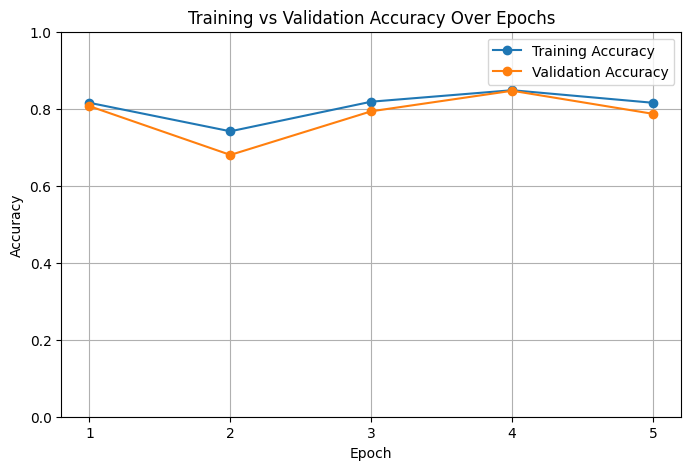

In [72]:
import matplotlib.pyplot as plt

def plot_accuracy_per_epoch(train_accs, val_accs):
    """
    Plots how training and validation accuracy change over epochs.
    - train_accs: list of training accuracy values per epoch
    - val_accs:   list of validation accuracy values per epoch
    """

    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accs, marker='o', label='Training Accuracy')
    plt.plot(epochs, val_accs, marker='o', label='Validation Accuracy')

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy Over Epochs")
    plt.xticks(epochs)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_accuracy_per_epoch(train_accuracies, validation_accuracies)


In [73]:
# Write a classify function for inference on new text messages

def classify_text(model, text, tokenizer, device, max_length):
    model.eval()
    input_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    input_ids = input_ids[:max_length]
    input_ids += [50256] * (max_length - len(input_ids))  # Pad with endoftext token ID
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension
    logits = model(input_tensor)[:, -1, :]  # Get logits for the last token
    probabilities = torch.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    return predicted_class, probabilities.squeeze().detach().cpu().numpy()


# Test the classify_text function
test_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.",
    "Hey, are we still on for lunch tomorrow?",
    "Free entry in a weekly competition to win FA Cup final tickets. Text WIN to 12345 to enter.",
    "Don't forget to pick up groceries on your way home."
]
for message in test_messages:
    predicted_class, probabilities = classify_text(
        model = model,
        text = message,
        tokenizer = tokenizer,
        device = device,
        max_length = train_dataset.max_length
    )
    label = "spam" if predicted_class == 1 else "ham"
    print(f"Message: {message}\nPredicted class: {label}, Probabilities: {probabilities}\n")



Message: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
Predicted class: ham, Probabilities: [0.5060316  0.49396846]

Message: Hey, are we still on for lunch tomorrow?
Predicted class: ham, Probabilities: [0.84595555 0.15404445]

Message: Free entry in a weekly competition to win FA Cup final tickets. Text WIN to 12345 to enter.
Predicted class: spam, Probabilities: [0.29880923 0.70119077]

Message: Don't forget to pick up groceries on your way home.
Predicted class: ham, Probabilities: [0.829075   0.17092505]



In [76]:
import gradio as gr

def gradio_classify_text(text):
    predicted_class, probabilities = classify_text(
        model = model,
        text = text,
        tokenizer = tokenizer,
        device = device,
        max_length = train_dataset.max_length
    )
    label = "spam" if predicted_class == 1 else "ham"
    return { "ham": float(probabilities[0]), "spam": float(probabilities[1]) }

iface = gr.Interface(
    fn=gradio_classify_text,
    inputs=gr.Textbox(lines=4, placeholder="Enter a text message here..."),
    outputs=gr.Label(num_top_classes=2, label="Predicted Class"),
    title="Spam Classifier using Fine-tuned GPT Model",
    description="Enter a text message to classify it as 'spam' or 'ham' using the fine-tuned GPT model."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
